# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


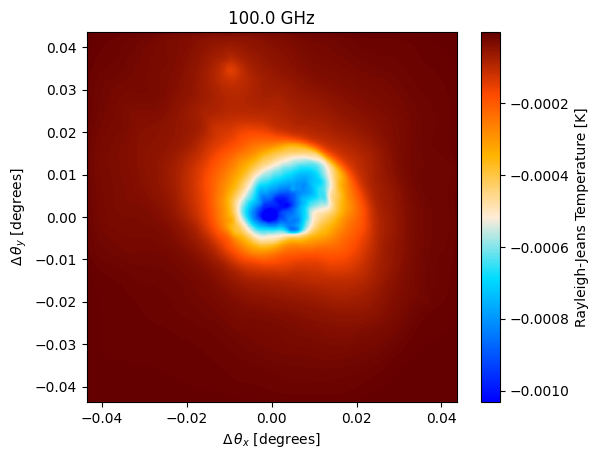

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

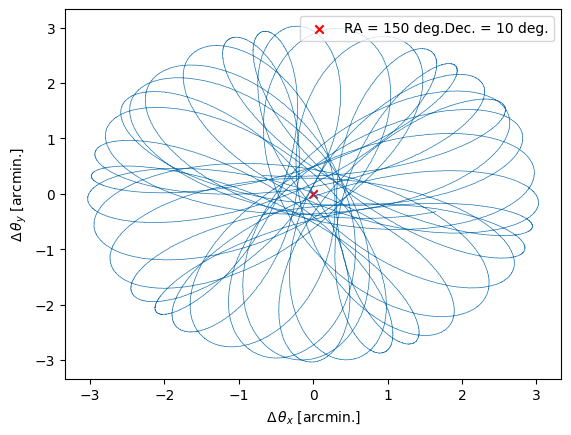

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-17 09:38:23.715 INFO: Initialized base in 1590 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
2024-10-17 09:38:29.391 INFO: Initialized atmosphere in 5662 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


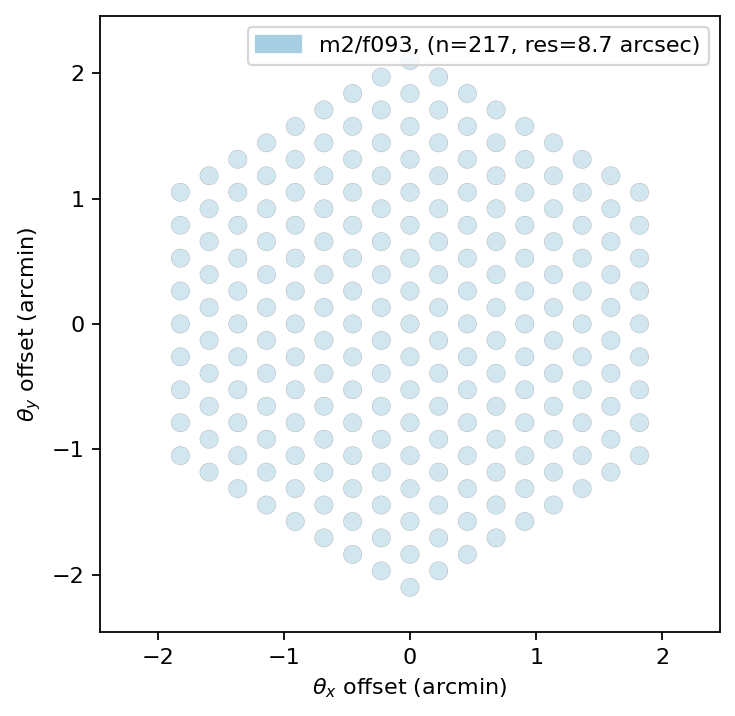

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96378119e-04, -1.93231133e-04, -1.90262104e-04, ...,
         4.73889430e-04,  4.77373284e-04,  4.80022161e-04],
       [-2.45497208e-04, -2.42350363e-04, -2.39381433e-04, ...,
         4.28542755e-04,  4.32026449e-04,  4.34675219e-04],
       [-1.21187929e-04, -1.18040975e-04, -1.15071968e-04, ...,
         5.49767421e-04,  5.53251253e-04,  5.55900116e-04],
       ...,
       [ 1.21384424e-04,  1.24532566e-04,  1.27502417e-04, ...,
         7.60784782e-04,  7.64269939e-04,  7.66919690e-04],
       [-4.04946913e-04, -4.01798548e-04, -3.98828538e-04, ...,
         2.29638836e-04,  2.33124148e-04,  2.35774003e-04],
       [-7.45757453e-04, -7.42610556e-04, -7.39641590e-04, ...,
        -7.20718816e-05, -6.85882142e-05, -6.59394618e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


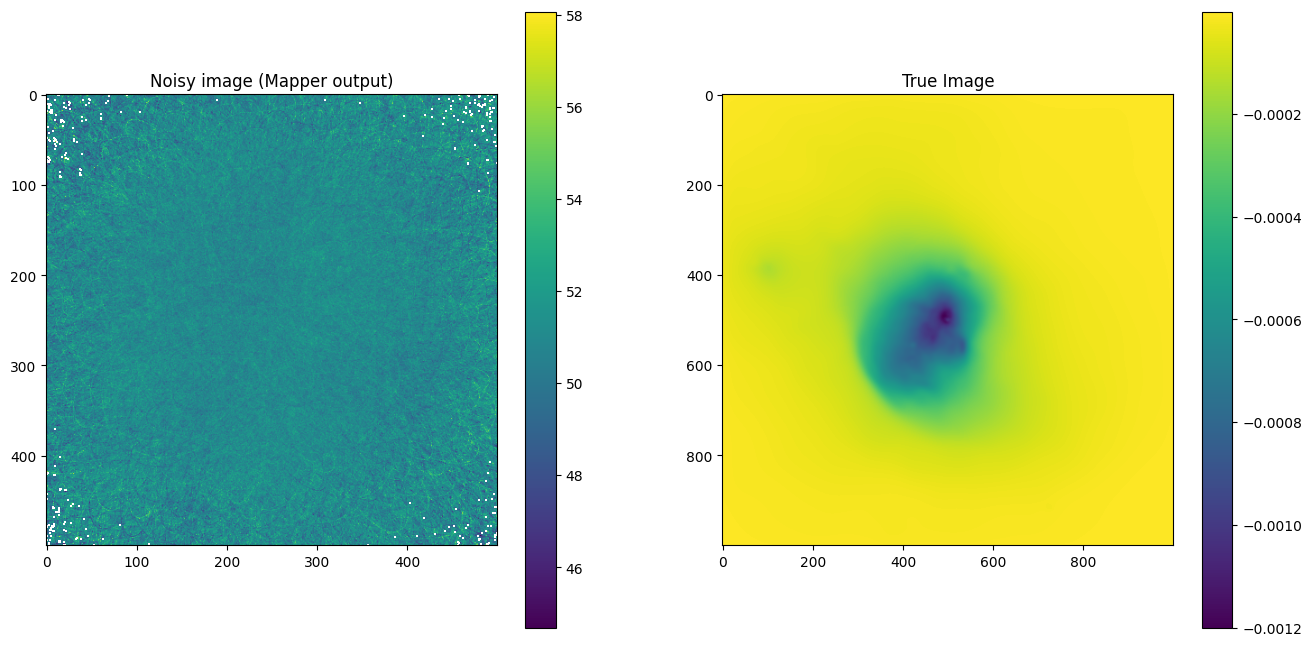

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-17 09:38:43.592 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-17 09:38:43.593 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Prepare noised input TODs:

Noise stddev: 0.0002511525733251761


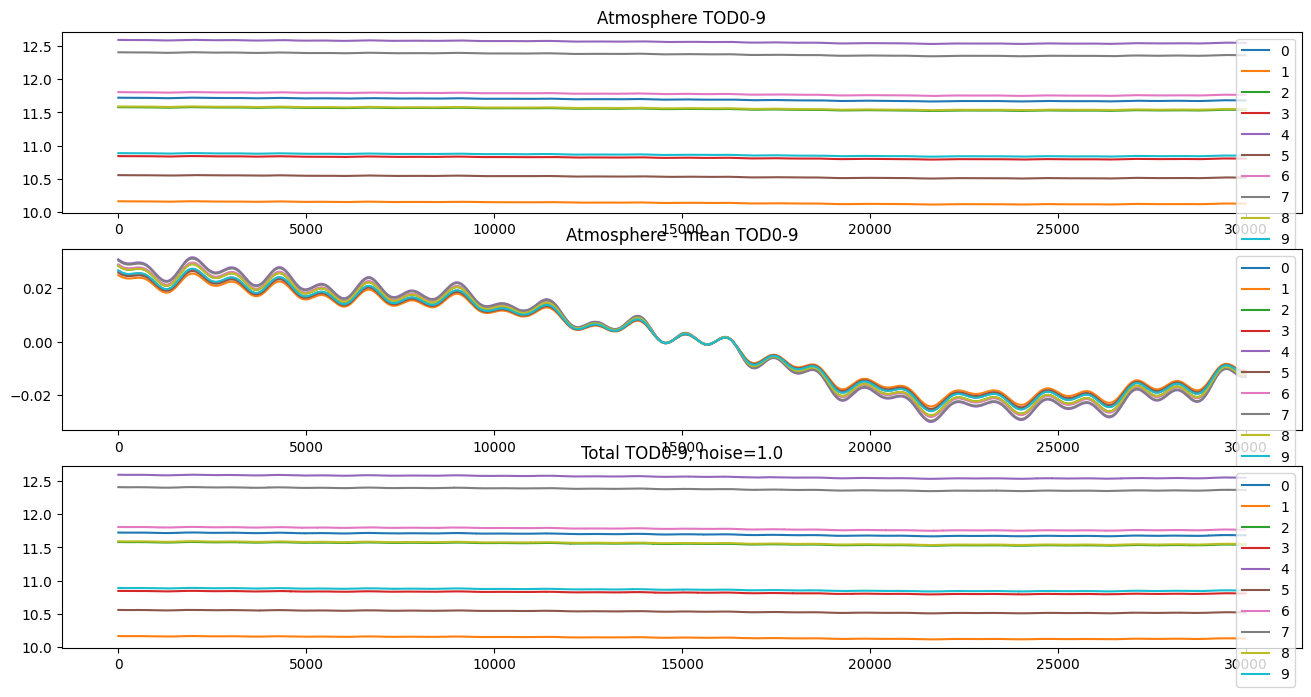

In [7]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods_atmos = tod_truthmap.get_field('atmosphere')

# Add n TODs for atmos:
# n = 1
n = 10
# n = 100
# n = jax_tods_atmos.shape[0]

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# # noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

noised_jax_tod = np.float64(jax_tods_atmos)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10):
    # im0 = axes[0].plot(jax_tods_map[i], label=i)
    im0 = axes[0].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean(), label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere - mean TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [8]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [9]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [10]:
# padding_atmos = 2000
padding_atmos = 5000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.02, 0.01))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.005), 
    fluctuations=(0.005, 0.003), 
    loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
# cfm_tod = CFM("combcf ")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# gp_tod = cfm_tod.finalize(n)

# Old: default CFM:
cfm_tod = jft.CorrelatedFieldMaker("")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# init params for each TOD:
gps_tods = []
for i in range(n):
    cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
    # cfmi.set_amplitude_total_offset(**cf_zm_tod)
    cfmi._azm = cfm_tod._azm
    cfmi._offset_mean = cfm_tod._offset_mean
    cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

    cfmi._fluctuations.append(cfm_tod._fluctuations[0])
    cfmi._target_grids.append(cfm_tod._target_grids[0])
    cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
    gps_tods.append(cfmi.finalize())

In [11]:
# gp_tod
gps_tods

[Model(
 	<function CorrelatedFieldMaker.finalize.<locals>.correlated_field at 0x14e93b4f8ae0>,
 	domain={'tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 	 'tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
 	 'tod0 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
 	 'zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
 	init=Initializer(
 		{'tod fluctuations': functools.partial(<function random_like at 0x14e9243ca200>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
 		 'tod loglogavgslope': functools.partial(<function random_like at 0x14e9243ca200>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
 		 'tod0 xi': functools.partial(<function random_like at 0x14e9243ca200>, primals=ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>)),
 		 'zeromode': functools.partial(<function random_like at 0x14e9243ca200>, primals=Shap

# OLD Signal model:

In [12]:
class Signal_TOD(jft.Model):
    def __init__(self, gps_tods):
        self.gps_tods = gps_tods
        self.tgt = (len(gps_tods), gps_tods[0].target.size)
        # self.gp_map = gp_map
        # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
        super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
    def __call__(self, x):
        res_tods = jnp.zeros(self.tgt)
        for i, gp in enumerate(self.gps_tods):
            res_tods = res_tods.at[i].set(gp(x))
        
        return res_tods[:, padding_atmos//2:-padding_atmos//2]

        # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

        # # Only add first n atmosphere tods, otherwise use map
        # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

        # return modified_res_map

signal_response_tod = Signal_TOD(gps_tods)

# Using CFM - combined

In [13]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_tod, gp_map):
#         self.gp_tod = gp_tod
#         self.gp_map = gp_map

#         super().__init__(init = self.gp_tod.init | self.gp_map.init, domain = self.gp_tod.domain | self.gp_map.domain)
#         # super().__init__(init = self.gp_tod.init | self.gp_map.init, domain = {'tod': self.gp_tod.domain, 'map': self.gp_map.domain} )
    
#     def __call__(self, x):
#         x_tod = {k: x[k] for k in x if 'map' not in k}
#         res_tods = self.gp_tod(x_tod)
#         # res_tods = self.gp_tod(x['tod'])

#         # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1]))[:, padding_map//2:-padding_map//2, padding_map//2:-padding_map//2], dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         # Only add first n atmosphere tods, otherwise use map
#         modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         return modified_res_map
    
# signal_response_tod = Signal_TOD(gp_tod, gp_map)

# CFM - TOD

In [14]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_tod):
#         self.gp_tod = gp_tod
#         super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
#     def __call__(self, x):
#         x_tod = {k: x[k] for k in x if 'map' not in k}
#         res_tods = self.gp_tod(x_tod)
#         # res_tods = self.gp_tod(x)

#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gp_tod)

In [15]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
print(noised_jax_tod.shape)
# truth = noised_jax_tod[:, 100:-100]
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(10, 30000)


In [16]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod0 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod1 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod2 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod3 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod4 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod5 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod6 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod7 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod8 xi': ShapeWithDtype(shape=(35000,), dtype=<class 'jax.numpy.float64'>),
	 'tod9 xi': ShapeWithDtype(shape=(35000,), dtype=<class

# Draw Prior sample

(10, 30000)


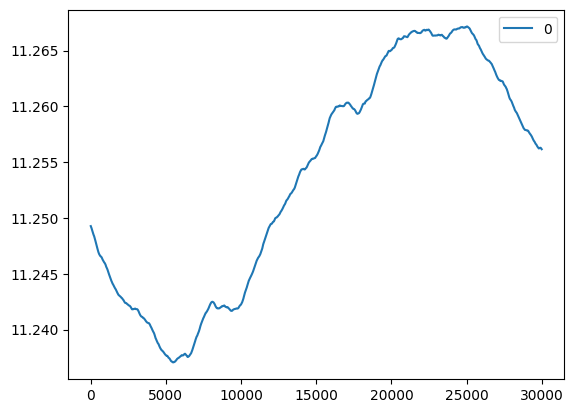

In [17]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [18]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:True #∇²:08 |↘|:1.403975e+03 ➽:3.500030e+01
M: Iteration 1 ⛰:+5.469762e+11 Δ⛰:8.253610e+11
M: →:0.5 ↺:False #∇²:14 |↘|:1.402230e+05 ➽:3.500030e+01
M: Iteration 2 ⛰:+1.497298e+11 Δ⛰:3.972465e+11
M: →:0.5 ↺:False #∇²:20 |↘|:7.011308e+04 ➽:3.500030e+01
M: Iteration 3 ⛰:+6.783537e+10 Δ⛰:8.189440e+10
M: →:1.0 ↺:True #∇²:27 |↘|:3.003562e-01 ➽:3.500030e+01
M: Iteration 4 ⛰:+4.777962e+09 Δ⛰:6.305741e+10
OPTIMIZE_KL: Iteration 0001 ⛰:+4.7780e+09
OPTIMIZE_KL: #(KL minimization steps) 4
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 3.2e+04±     0.0, avg: -7.6e+01±     0.0, #dof: 300000'

OPTIMIZE_KL: Prior residual(s):
tod fluctuations        :: 'reduced χ²: 4.6e+02±     0.0, avg: -2.1e+01±     0.0, #dof:      1'
tod loglogavgslope      :: 'reduced χ²:    0.61±     0.0, avg:    +0.78±     0.0, #dof:      1'
tod0 xi                 :: 'reduced χ²:   0.065±     0.0, avg:  +0.0011±     0.0, #dof:  35000'
tod1 xi                 :: 'reduced χ²:    0.08±     0

In [19]:
samples.pos

Vector(
	{'tod fluctuations': Array(-21.40213063, dtype=float64),
	 'tod loglogavgslope': Array(0.77795218, dtype=float64),
	 'tod0 xi': Array([ 1.0082859 , -7.67471728, -1.74699593, ..., -0.54465276,
	       -1.79482578, -5.0849304 ], dtype=float64),
	 'tod1 xi': Array([-2.61583971, 15.24500939,  4.83552117, ...,  2.69518953,
	        5.1727864 , 17.36610388], dtype=float64),
	 'tod2 xi': Array([ 0.60948191, -5.49670412, -1.30749321, ..., -1.244951  ,
	       -0.68269613, -3.12961935], dtype=float64),
	 'tod3 xi': Array([-0.94669131,  5.35115084,  2.52286819, ...,  0.72423095,
	        1.704729  ,  7.51840242], dtype=float64),
	 'tod4 xi': Array([  3.14195268, -20.18849185,  -5.82478783, ...,  -2.69027012,
	        -6.02569655, -17.59504375], dtype=float64),
	 'tod5 xi': Array([-1.71862673,  9.41980819,  3.49436817, ...,  1.19334095,
	        3.64440836, 11.71885336], dtype=float64),
	 'tod6 xi': Array([ 1.35894375, -8.67179228, -2.66861182, ..., -0.95114021,
	       -2.52130932, -6.3

In [20]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # NEW model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
    # print("map:")
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 3.006752930130222e-08, 0.005, 0.003
	loglogvarslope: -2.611023912128324, -3, 0.5
	zeromode std (LogNormal): 0.43614130113504, 0.0005, 0.001


(10, 30000)


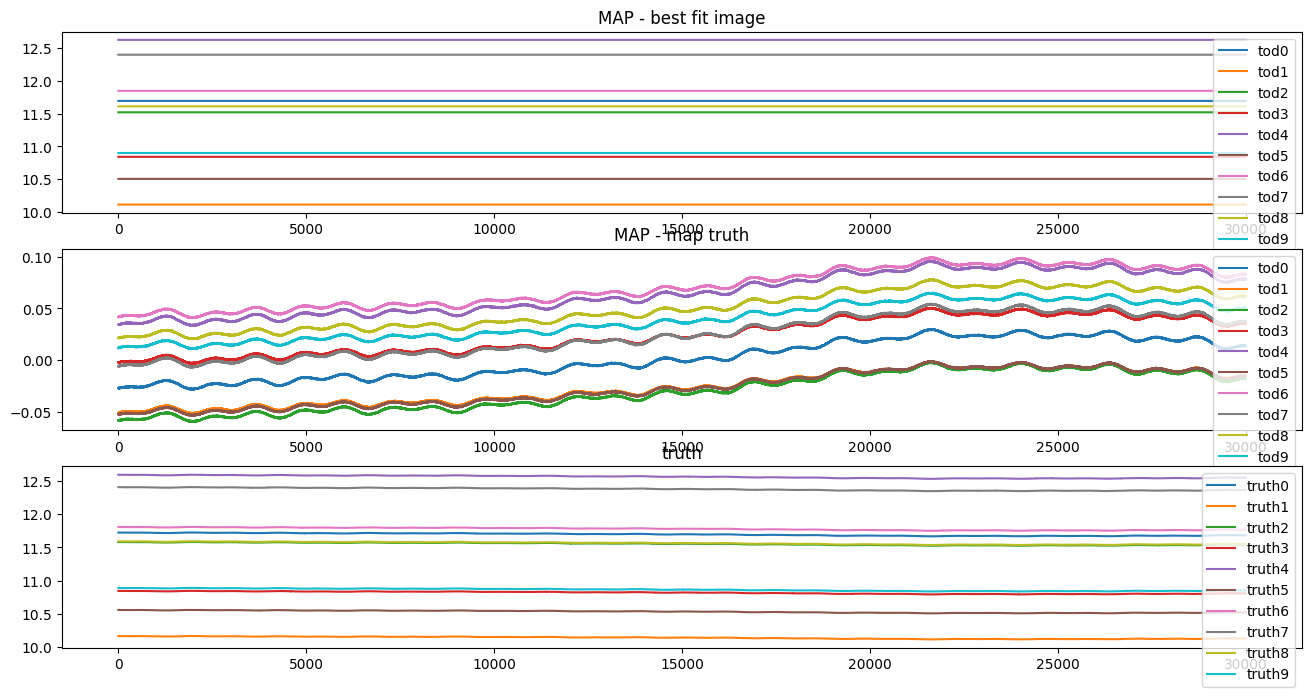

In [21]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in range(0, n, n//10):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [22]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+2.5728e+08 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+9.2452e+07 Δ⛰:1.6482e+08 ➽:3.5000e+00
SL: Iteration 2 ⛰:+5.2991e+07 Δ⛰:3.9461e+07 ➽:3.5000e+00
SL: Iteration 3 ⛰:+1.2975e+07 Δ⛰:4.0016e+07 ➽:3.5000e+00
SL: Iteration 4 ⛰:+7.0572e+06 Δ⛰:5.9182e+06 ➽:3.5000e+00
SL: Iteration 5 ⛰:+4.7888e+06 Δ⛰:2.2684e+06 ➽:3.5000e+00
SL: Iteration 6 ⛰:+2.6485e+06 Δ⛰:2.1403e+06 ➽:3.5000e+00
SL: Iteration 7 ⛰:+2.3571e+06 Δ⛰:2.9134e+05 ➽:3.5000e+00
SL: Iteration 8 ⛰:+1.9789e+06 Δ⛰:3.7824e+05 ➽:3.5000e+00
SL: Iteration 9 ⛰:+1.4596e+06 Δ⛰:5.1929e+05 ➽:3.5000e+00
SL: Iteration 10 ⛰:+1.2572e+06 Δ⛰:2.0237e+05 ➽:3.5000e+00
SL: Iteration 11 ⛰:+1.1082e+06 Δ⛰:1.4902e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+8.0544e+05 Δ⛰:3.0276e+05 ➽:3.5000e+00
SL: Iteration 13 ⛰:+8.0239e+05 Δ⛰:3.0531e+03 ➽:3.5000e+00
SL: Iteration 14 ⛰:+6.8704e+05 Δ⛰:1.1535e+05 ➽:3.5000e+00
SL: Iteration 15 ⛰:+6.4379e+05 Δ⛰:4.3247e+04 ➽:3.5000e+00
SL: Iteration 16 ⛰:+4.2807e+05 Δ⛰:2.1572e+05 ➽:3.5000e+00
SL: 

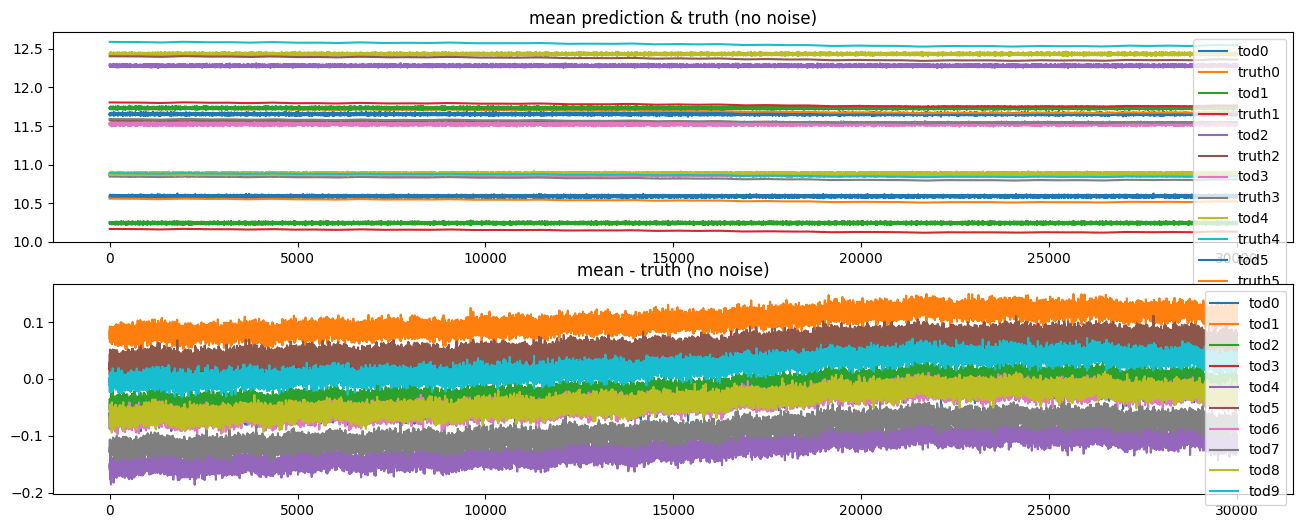

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.7886e+12 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+6.6595e+09 Δ⛰:1.7819e+12 ➽:3.5000e+00
SL: Iteration 2 ⛰:+1.5667e+08 Δ⛰:6.5028e+09 ➽:3.5000e+00
SL: Iteration 3 ⛰:+1.5614e+08 Δ⛰:5.3223e+05 ➽:3.5000e+00
SL: Iteration 4 ⛰:+1.5609e+08 Δ⛰:4.7412e+04 ➽:3.5000e+00
SL: Iteration 5 ⛰:+1.5491e+08 Δ⛰:1.1842e+06 ➽:3.5000e+00
SL: Iteration 6 ⛰:+1.5364e+08 Δ⛰:1.2695e+06 ➽:3.5000e+00
SL: Iteration 7 ⛰:+2.4658e+07 Δ⛰:1.2898e+08 ➽:3.5000e+00
SL: Iteration 8 ⛰:+2.4658e+07 Δ⛰:1.3298e-01 ➽:3.5000e+00
SL: Iteration 0 ⛰:+8.1895e+11 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+2.4118e+10 Δ⛰:7.9484e+11 ➽:3.5000e+00
SL: Iteration 2 ⛰:+1.5608e+08 Δ⛰:2.3962e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+1.5588e+08 Δ⛰:1.9873e+05 ➽:3.5000e+00
SL: Iteration 4 ⛰:+1.5577e+08 Δ⛰:1.0860e+05 ➽:3.5000e+00
SL: Iteration 5 ⛰:+1.5419e+08 Δ⛰:1.5823e+06 ➽:3.5000e+00
SL: Iteration 6 ⛰:+1.5385e+08 Δ⛰:3.3806e+05 ➽:3.5000e+00
SL: Iteration 7 ⛰:+2.4608e+07 Δ⛰:1.2925e+08 ➽:3.5000e+00
SL: Iteration 8 ⛰:

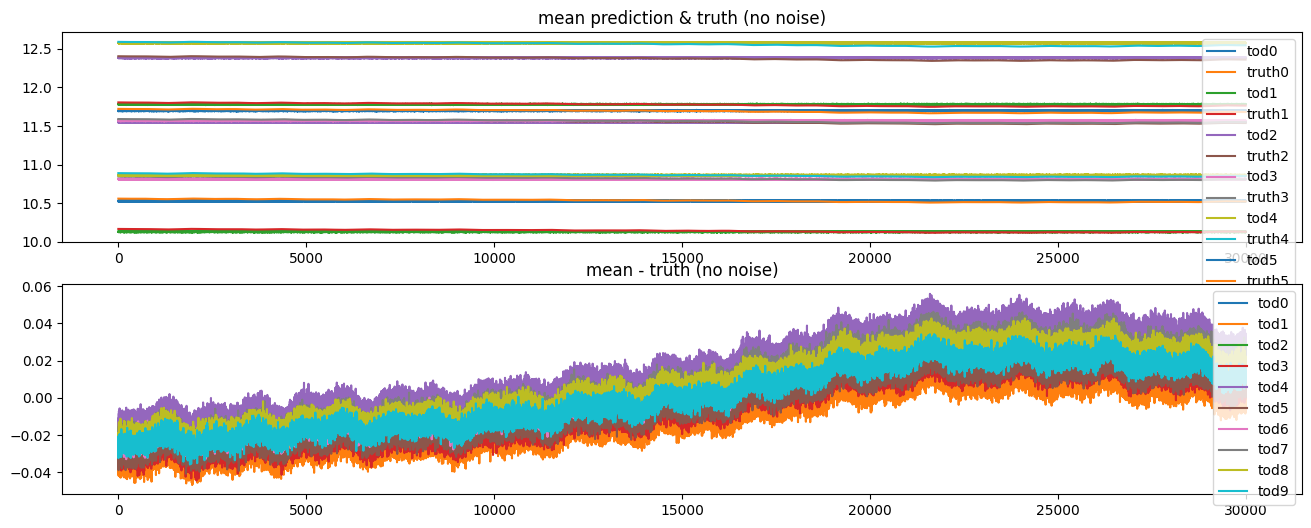

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+4.9072e+12 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+1.8787e+10 Δ⛰:4.8884e+12 ➽:3.5000e+00
SL: Iteration 2 ⛰:+3.3443e+07 Δ⛰:1.8754e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+2.1684e+07 Δ⛰:1.1760e+07 ➽:3.5000e+00
SL: Iteration 4 ⛰:+2.1684e+07 Δ⛰:1.4698e+01 ➽:3.5000e+00
SL: Iteration 5 ⛰:+2.0767e+07 Δ⛰:9.1686e+05 ➽:3.5000e+00
SL: Iteration 6 ⛰:+2.0767e+07 Δ⛰:4.3491e+00 ➽:3.5000e+00
SL: Iteration 7 ⛰:+3.1694e+06 Δ⛰:1.7598e+07 ➽:3.5000e+00
SL: Iteration 8 ⛰:+3.1683e+06 Δ⛰:1.0743e+03 ➽:3.5000e+00
SL: Iteration 9 ⛰:+9.1254e+05 Δ⛰:2.2557e+06 ➽:3.5000e+00
SL: Iteration 10 ⛰:+9.0757e+05 Δ⛰:4.9664e+03 ➽:3.5000e+00
SL: Iteration 11 ⛰:+9.0757e+05 Δ⛰:1.5959e-03 ➽:3.5000e+00
SL: Iteration 0 ⛰:+7.0860e+11 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+1.0250e+10 Δ⛰:6.9835e+11 ➽:3.5000e+00
SL: Iteration 2 ⛰:+2.2487e+07 Δ⛰:1.0227e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+2.0706e+07 Δ⛰:1.7816e+06 ➽:3.5000e+00
SL: Iteration 4 ⛰:+2.0706e+07 Δ⛰:1.0739e-01 ➽:3.5000e+00
SL: Iteration 5 

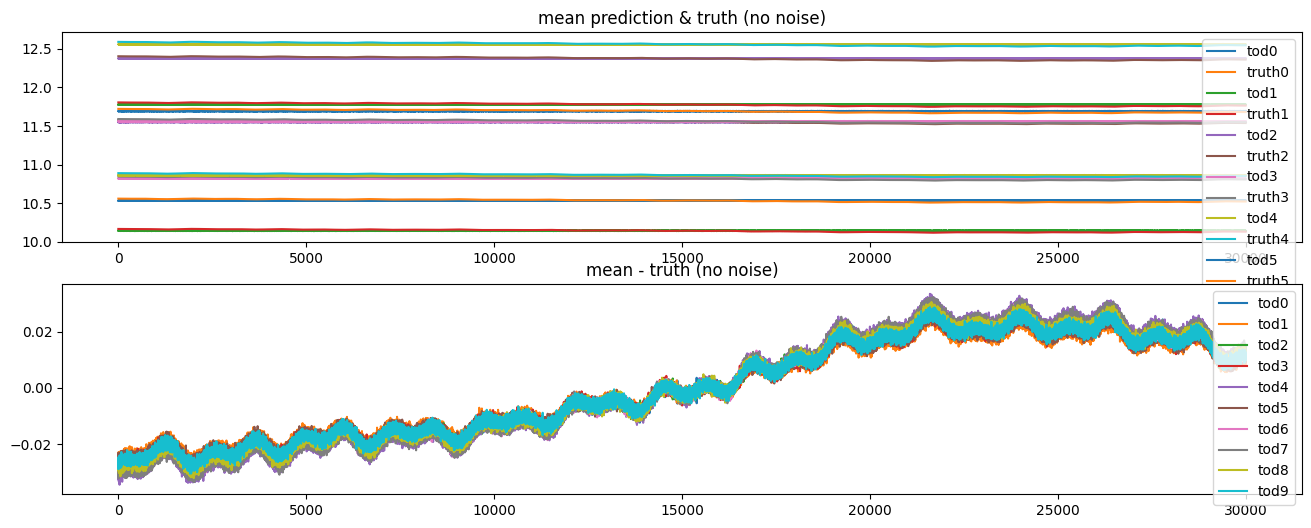

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+4.0637e+12 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+1.2924e+10 Δ⛰:4.0508e+12 ➽:3.5000e+00
SL: Iteration 2 ⛰:+3.3843e+06 Δ⛰:1.2921e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+2.6790e+06 Δ⛰:7.0530e+05 ➽:3.5000e+00
SL: Iteration 4 ⛰:+2.6790e+06 Δ⛰:2.0050e-01 ➽:3.5000e+00
SL: Iteration 5 ⛰:+2.6660e+06 Δ⛰:1.3032e+04 ➽:3.5000e+00
SL: Iteration 6 ⛰:+2.6659e+06 Δ⛰:9.7978e+01 ➽:3.5000e+00
SL: Iteration 7 ⛰:+2.6647e+06 Δ⛰:1.1550e+03 ➽:3.5000e+00
SL: Iteration 8 ⛰:+2.5676e+05 Δ⛰:2.4079e+06 ➽:3.5000e+00
SL: Iteration 9 ⛰:+2.2248e+05 Δ⛰:3.4280e+04 ➽:3.5000e+00
SL: Iteration 10 ⛰:+3.1007e+04 Δ⛰:1.9147e+05 ➽:3.5000e+00
SL: Iteration 11 ⛰:-4.4731e+04 Δ⛰:7.5738e+04 ➽:3.5000e+00
SL: Iteration 12 ⛰:-4.5234e+04 Δ⛰:5.0326e+02 ➽:3.5000e+00
SL: Iteration 13 ⛰:-4.5261e+04 Δ⛰:2.6230e+01 ➽:3.5000e+00
SL: Iteration 14 ⛰:-1.2251e+05 Δ⛰:7.7247e+04 ➽:3.5000e+00
SL: Iteration 15 ⛰:-1.2266e+05 Δ⛰:1.5432e+02 ➽:3.5000e+00
SL: Iteration 16 ⛰:-1.5056e+05 Δ⛰:2.7902e+04 ➽:3.5000e+00
SL: 

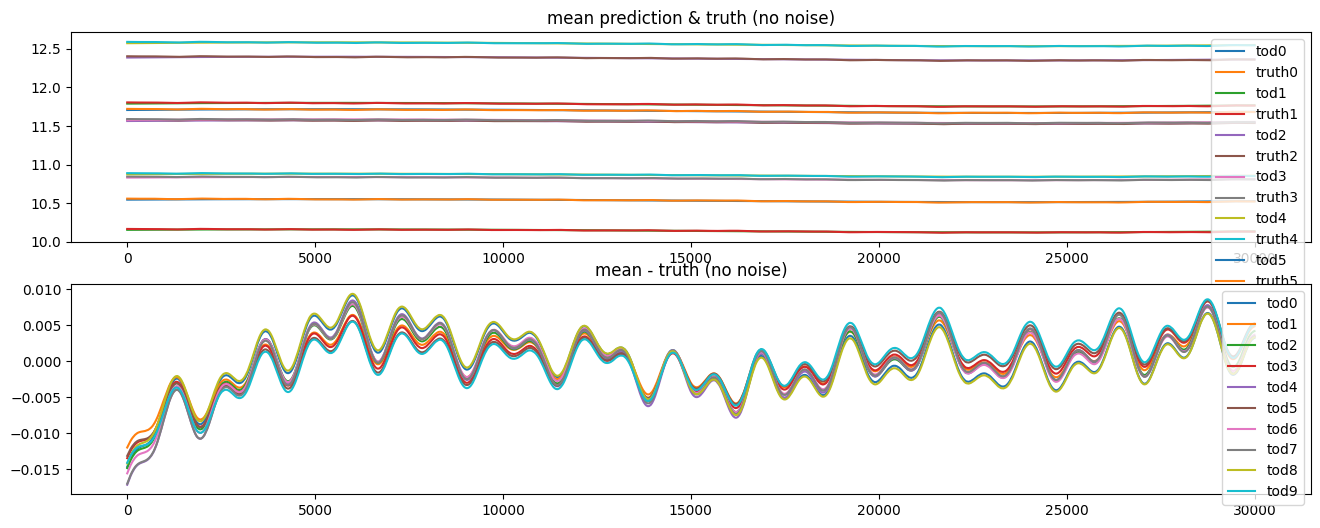

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+2.1558e+12 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+1.0994e+10 Δ⛰:2.1449e+12 ➽:3.5000e+00
SL: Iteration 2 ⛰:+3.7108e+08 Δ⛰:1.0623e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+3.1545e+07 Δ⛰:3.3954e+08 ➽:3.5000e+00
SL: Iteration 4 ⛰:+3.1328e+07 Δ⛰:2.1785e+05 ➽:3.5000e+00
SL: Iteration 5 ⛰:+3.1325e+07 Δ⛰:2.1391e+03 ➽:3.5000e+00
SL: Iteration 6 ⛰:+2.6533e+06 Δ⛰:2.8672e+07 ➽:3.5000e+00
SL: Iteration 7 ⛰:+1.6409e+06 Δ⛰:1.0124e+06 ➽:3.5000e+00
SL: Iteration 8 ⛰:+1.5489e+06 Δ⛰:9.1946e+04 ➽:3.5000e+00
SL: Iteration 9 ⛰:+8.5568e+05 Δ⛰:6.9325e+05 ➽:3.5000e+00
SL: Iteration 10 ⛰:+3.9121e+05 Δ⛰:4.6447e+05 ➽:3.5000e+00
SL: Iteration 11 ⛰:+1.8250e+05 Δ⛰:2.0871e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+1.8250e+05 Δ⛰:5.8382e-01 ➽:3.5000e+00
SL: Iteration 0 ⛰:+2.0500e+12 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+1.7468e+10 Δ⛰:2.0325e+12 ➽:3.5000e+00
SL: Iteration 2 ⛰:+4.7743e+07 Δ⛰:1.7420e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+2.9099e+07 Δ⛰:1.8644e+07 ➽:3.5000e+00
SL: Iteration 4

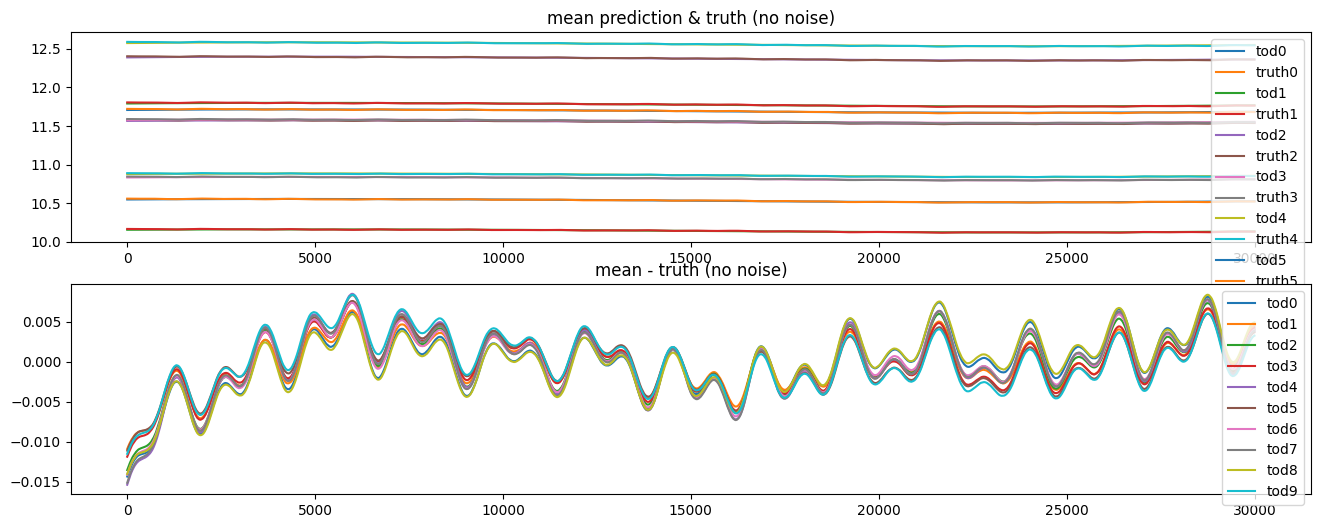

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+3.5744e+11 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+2.2036e+10 Δ⛰:3.3540e+11 ➽:3.5000e+00
SL: Iteration 2 ⛰:+1.8080e+08 Δ⛰:2.1855e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+2.2561e+07 Δ⛰:1.5824e+08 ➽:3.5000e+00
SL: Iteration 4 ⛰:+8.3890e+06 Δ⛰:1.4172e+07 ➽:3.5000e+00
SL: Iteration 5 ⛰:+7.7076e+06 Δ⛰:6.8133e+05 ➽:3.5000e+00
SL: Iteration 6 ⛰:+5.2166e+06 Δ⛰:2.4910e+06 ➽:3.5000e+00
SL: Iteration 7 ⛰:+3.4655e+06 Δ⛰:1.7511e+06 ➽:3.5000e+00
SL: Iteration 8 ⛰:+3.4116e+06 Δ⛰:5.3851e+04 ➽:3.5000e+00
SL: Iteration 9 ⛰:+3.4088e+06 Δ⛰:2.8175e+03 ➽:3.5000e+00
SL: Iteration 10 ⛰:+9.5549e+05 Δ⛰:2.4533e+06 ➽:3.5000e+00
SL: Iteration 11 ⛰:+4.7189e+05 Δ⛰:4.8361e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+4.7187e+05 Δ⛰:1.4451e+01 ➽:3.5000e+00
SL: Iteration 13 ⛰:+3.9477e+05 Δ⛰:7.7103e+04 ➽:3.5000e+00
SL: Iteration 14 ⛰:+3.8790e+05 Δ⛰:6.8692e+03 ➽:3.5000e+00
SL: Iteration 15 ⛰:+3.4857e+05 Δ⛰:3.9328e+04 ➽:3.5000e+00
SL: Iteration 16 ⛰:+2.2615e+05 Δ⛰:1.2242e+05 ➽:3.5000e+00
SL: 

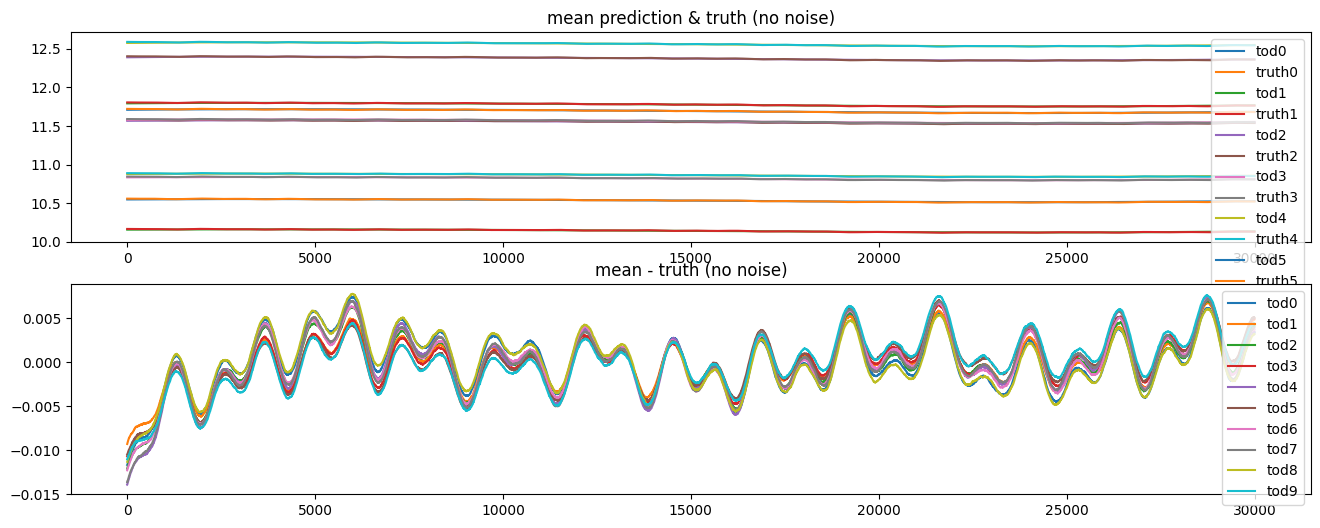

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+1.1060e+11 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+2.0173e+10 Δ⛰:9.0424e+10 ➽:3.5000e+00
SL: Iteration 2 ⛰:+5.2033e+08 Δ⛰:1.9653e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+2.4887e+07 Δ⛰:4.9545e+08 ➽:3.5000e+00
SL: Iteration 4 ⛰:+2.4844e+07 Δ⛰:4.3232e+04 ➽:3.5000e+00
SL: Iteration 5 ⛰:+2.3177e+07 Δ⛰:1.6666e+06 ➽:3.5000e+00
SL: Iteration 6 ⛰:+6.4760e+06 Δ⛰:1.6701e+07 ➽:3.5000e+00
SL: Iteration 7 ⛰:+4.1966e+06 Δ⛰:2.2794e+06 ➽:3.5000e+00
SL: Iteration 8 ⛰:+2.9649e+06 Δ⛰:1.2317e+06 ➽:3.5000e+00
SL: Iteration 9 ⛰:+2.9554e+06 Δ⛰:9.4933e+03 ➽:3.5000e+00
SL: Iteration 10 ⛰:+2.4002e+06 Δ⛰:5.5516e+05 ➽:3.5000e+00
SL: Iteration 11 ⛰:+1.8847e+06 Δ⛰:5.1555e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+1.0367e+06 Δ⛰:8.4802e+05 ➽:3.5000e+00
SL: Iteration 13 ⛰:+1.0366e+06 Δ⛰:7.0468e+01 ➽:3.5000e+00
SL: Iteration 14 ⛰:+1.0342e+06 Δ⛰:2.4251e+03 ➽:3.5000e+00
SL: Iteration 15 ⛰:+1.0336e+06 Δ⛰:5.4733e+02 ➽:3.5000e+00
SL: Iteration 16 ⛰:+8.9425e+05 Δ⛰:1.3936e+05 ➽:3.5000e+00
SL: 

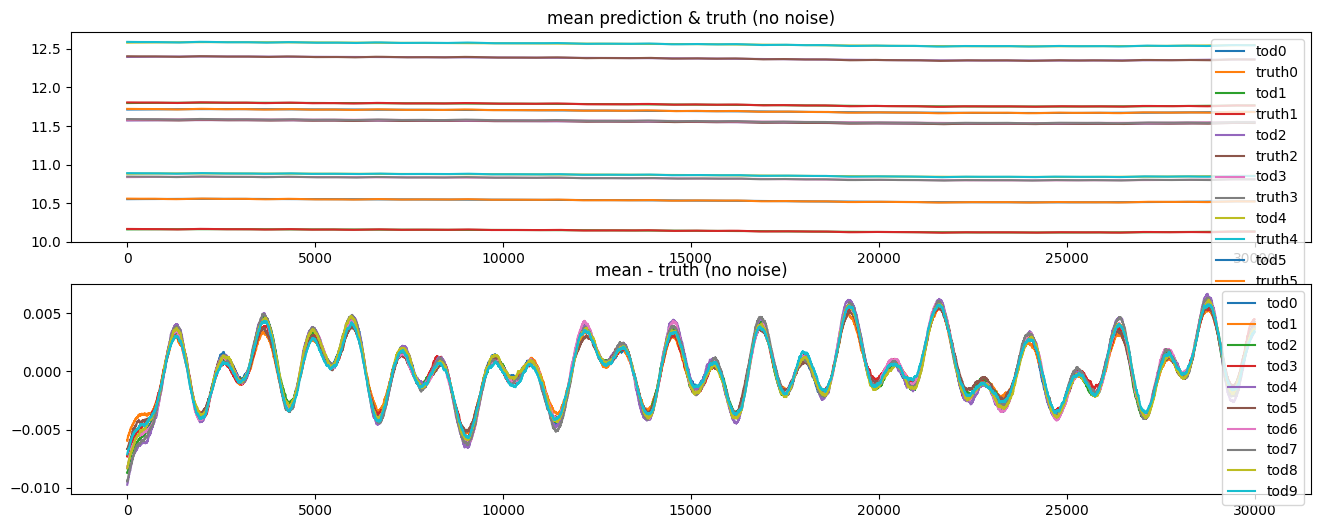

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+1.4082e+12 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+5.6697e+10 Δ⛰:1.3515e+12 ➽:3.5000e+00
SL: Iteration 2 ⛰:+1.5651e+08 Δ⛰:5.6540e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+3.9570e+07 Δ⛰:1.1694e+08 ➽:3.5000e+00
SL: Iteration 4 ⛰:+3.9501e+07 Δ⛰:6.8103e+04 ➽:3.5000e+00
SL: Iteration 5 ⛰:+3.9468e+07 Δ⛰:3.3502e+04 ➽:3.5000e+00
SL: Iteration 6 ⛰:+9.3456e+06 Δ⛰:3.0122e+07 ➽:3.5000e+00
SL: Iteration 7 ⛰:+5.8070e+06 Δ⛰:3.5386e+06 ➽:3.5000e+00
SL: Iteration 8 ⛰:+5.8033e+06 Δ⛰:3.6394e+03 ➽:3.5000e+00
SL: Iteration 9 ⛰:+5.8004e+06 Δ⛰:2.9316e+03 ➽:3.5000e+00
SL: Iteration 10 ⛰:+2.6171e+06 Δ⛰:3.1833e+06 ➽:3.5000e+00
SL: Iteration 11 ⛰:+2.0064e+06 Δ⛰:6.1071e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+1.3472e+06 Δ⛰:6.5918e+05 ➽:3.5000e+00
SL: Iteration 13 ⛰:+1.3471e+06 Δ⛰:1.3549e+02 ➽:3.5000e+00
SL: Iteration 14 ⛰:+1.3464e+06 Δ⛰:7.1418e+02 ➽:3.5000e+00
SL: Iteration 15 ⛰:+1.3462e+06 Δ⛰:1.8612e+02 ➽:3.5000e+00
SL: Iteration 16 ⛰:+1.1716e+06 Δ⛰:1.7458e+05 ➽:3.5000e+00
SL: 

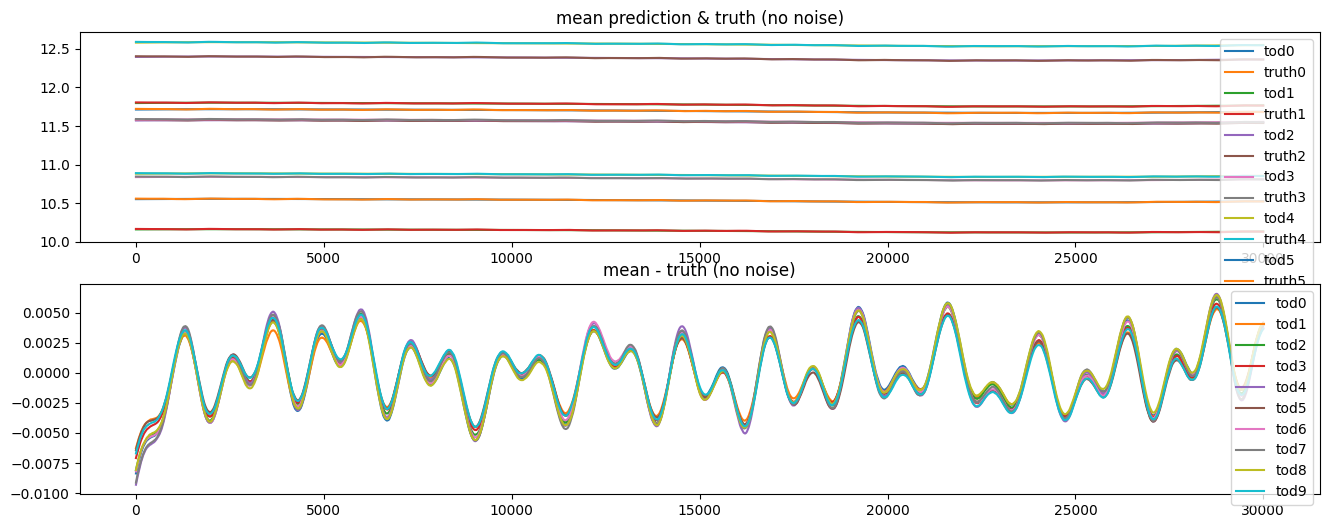

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+1.2019e+11 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+2.0928e+10 Δ⛰:9.9262e+10 ➽:3.5000e+00
SL: Iteration 2 ⛰:+3.6427e+08 Δ⛰:2.0564e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+3.7110e+07 Δ⛰:3.2716e+08 ➽:3.5000e+00
SL: Iteration 4 ⛰:+3.6769e+07 Δ⛰:3.4119e+05 ➽:3.5000e+00
SL: Iteration 5 ⛰:+3.6759e+07 Δ⛰:9.9005e+03 ➽:3.5000e+00
SL: Iteration 6 ⛰:+6.2556e+06 Δ⛰:3.0503e+07 ➽:3.5000e+00
SL: Iteration 7 ⛰:+4.2030e+06 Δ⛰:2.0525e+06 ➽:3.5000e+00
SL: Iteration 8 ⛰:+4.1881e+06 Δ⛰:1.4958e+04 ➽:3.5000e+00
SL: Iteration 9 ⛰:+4.1880e+06 Δ⛰:8.2287e+01 ➽:3.5000e+00
SL: Iteration 10 ⛰:+1.8676e+06 Δ⛰:2.3204e+06 ➽:3.5000e+00
SL: Iteration 11 ⛰:+1.4520e+06 Δ⛰:4.1564e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+1.3326e+06 Δ⛰:1.1938e+05 ➽:3.5000e+00
SL: Iteration 13 ⛰:+8.9267e+05 Δ⛰:4.3994e+05 ➽:3.5000e+00
SL: Iteration 14 ⛰:+8.9062e+05 Δ⛰:2.0491e+03 ➽:3.5000e+00
SL: Iteration 15 ⛰:+8.8856e+05 Δ⛰:2.0566e+03 ➽:3.5000e+00
SL: Iteration 16 ⛰:+6.6013e+05 Δ⛰:2.2843e+05 ➽:3.5000e+00
SL: 

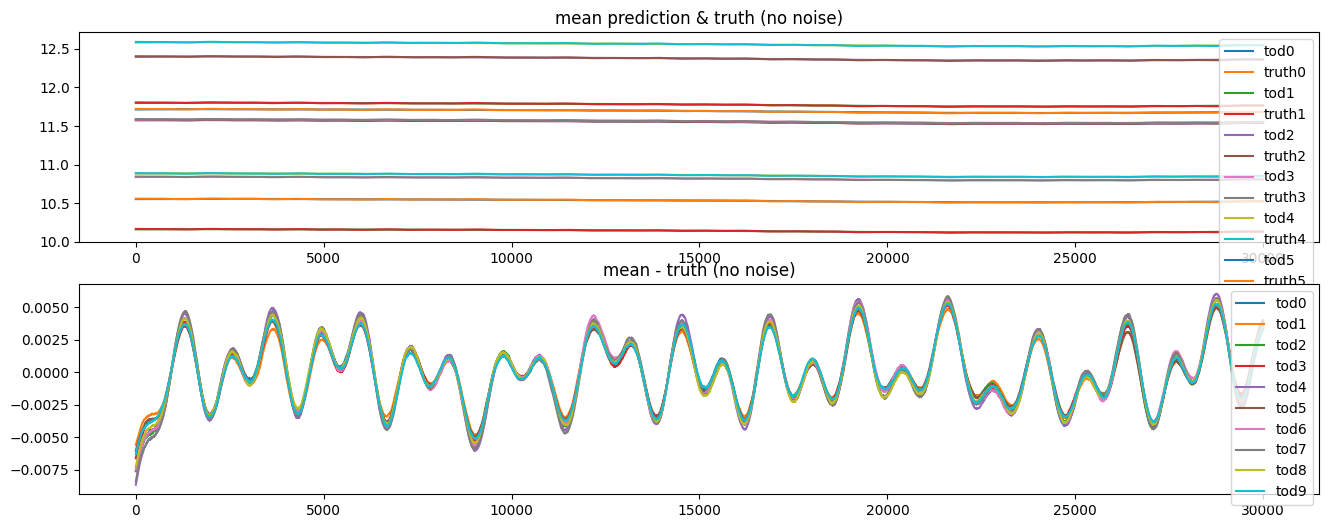

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+4.5141e+11 Δ⛰:inf ➽:3.5000e+00
SL: Iteration 1 ⛰:+3.8659e+10 Δ⛰:4.1275e+11 ➽:3.5000e+00
SL: Iteration 2 ⛰:+1.1042e+08 Δ⛰:3.8549e+10 ➽:3.5000e+00
SL: Iteration 3 ⛰:+4.6952e+07 Δ⛰:6.3463e+07 ➽:3.5000e+00
SL: Iteration 4 ⛰:+4.6826e+07 Δ⛰:1.2592e+05 ➽:3.5000e+00
SL: Iteration 5 ⛰:+4.6825e+07 Δ⛰:1.2958e+03 ➽:3.5000e+00
SL: Iteration 6 ⛰:+7.2442e+06 Δ⛰:3.9581e+07 ➽:3.5000e+00
SL: Iteration 7 ⛰:+5.0320e+06 Δ⛰:2.2123e+06 ➽:3.5000e+00
SL: Iteration 8 ⛰:+5.0249e+06 Δ⛰:7.0262e+03 ➽:3.5000e+00
SL: Iteration 9 ⛰:+5.0249e+06 Δ⛰:5.4436e+01 ➽:3.5000e+00
SL: Iteration 10 ⛰:+2.7766e+06 Δ⛰:2.2483e+06 ➽:3.5000e+00
SL: Iteration 11 ⛰:+1.8604e+06 Δ⛰:9.1616e+05 ➽:3.5000e+00
SL: Iteration 12 ⛰:+1.8599e+06 Δ⛰:5.6915e+02 ➽:3.5000e+00
SL: Iteration 13 ⛰:+1.4993e+06 Δ⛰:3.6063e+05 ➽:3.5000e+00
SL: Iteration 14 ⛰:+1.4891e+06 Δ⛰:1.0102e+04 ➽:3.5000e+00
SL: Iteration 15 ⛰:+1.4872e+06 Δ⛰:1.9532e+03 ➽:3.5000e+00
SL: Iteration 16 ⛰:+1.3443e+06 Δ⛰:1.4291e+05 ➽:3.5000e+00
SL: 

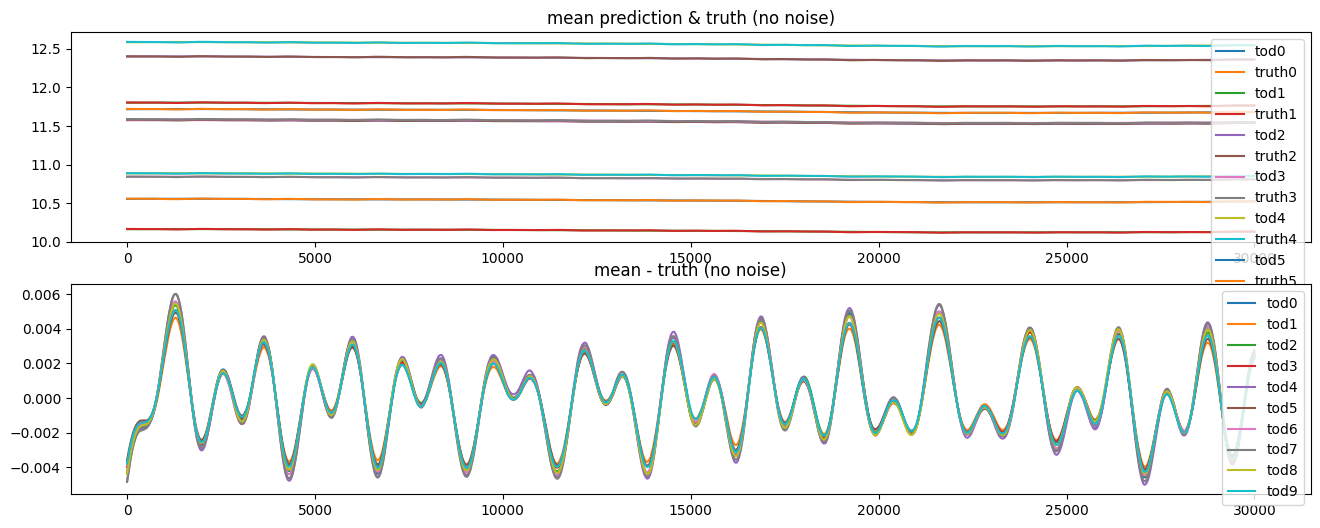

In [23]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    # for i in range(n):
    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [24]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.004151214909364045, 0.005, 0.003
	loglogvarslope: -2.849251410727361, -3, 0.5
	zeromode std (LogNormal): 0.1001411614767388, 0.0005, 0.001


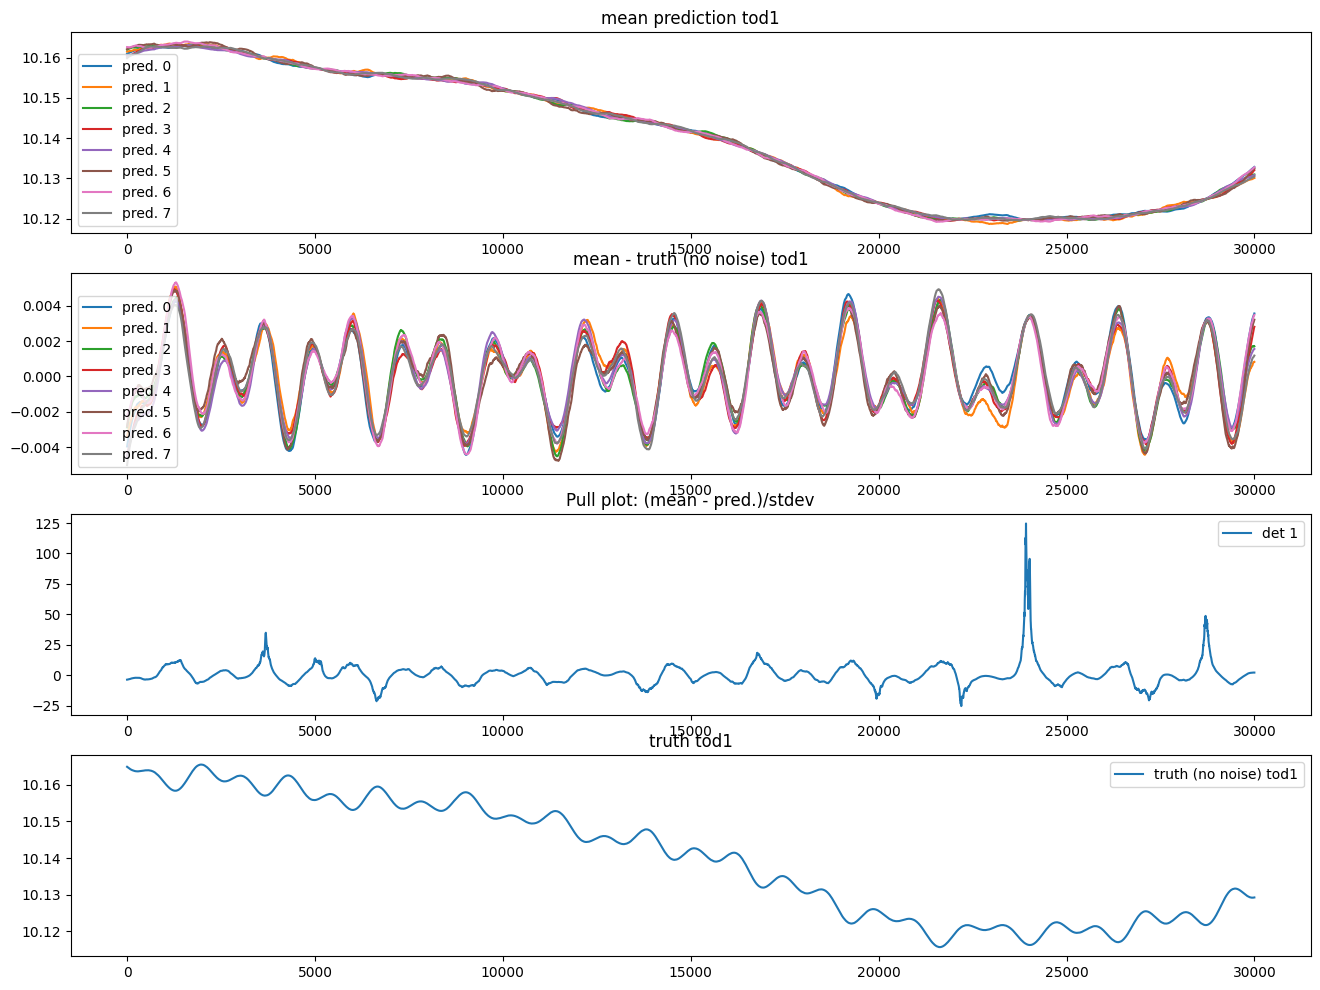

In [25]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

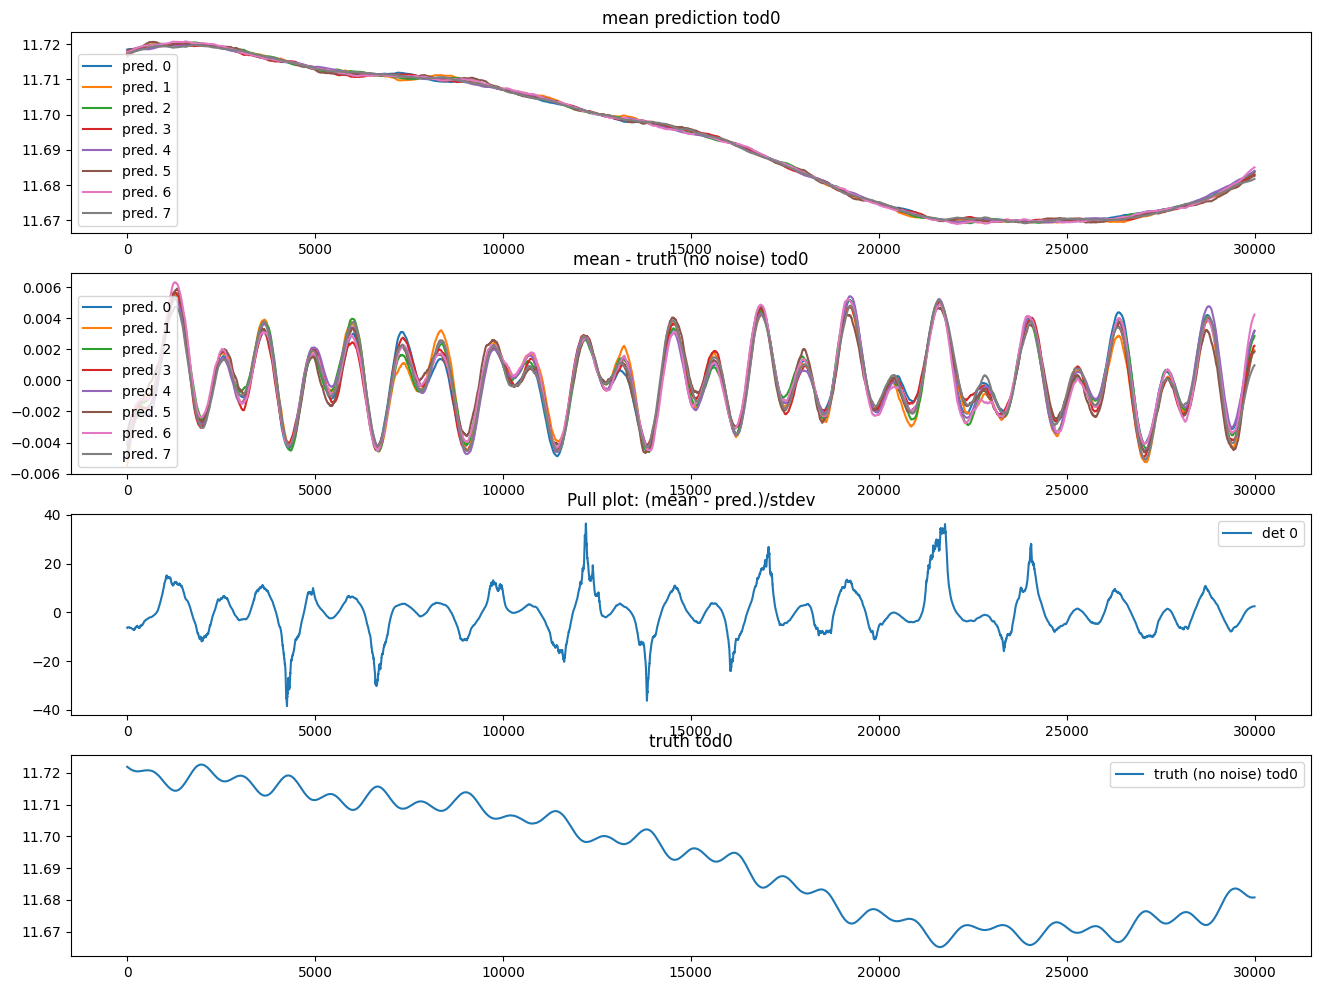

In [26]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()